## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## Load Dataset

In [2]:
df = pd.read_csv('Marketing_Attribution_Dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(10)

,user_id,timestamp,channel,touchpoint_number,converted,revenue
0,1,2024-12-08,Instagram,1,1,0.00
1,1,2024-12-21,Google,3,1,71.36
2,1,2024-12-29,Facebook,2,1,0.00
3,2,2024-12-11,Google,1,1,0.00
4,2,2024-12-21,Direct,3,1,47.99
5,2,2024-12-24,Direct,2,1,0.00
6,3,2024-12-02,Facebook,4,0,0.00
7,3,2024-12-03,Referral,1,0,0.00
8,3,2024-12-21,Email,3,0,0.00
9,3,2024-12-22,Facebook,2,0,0.00


## Explore Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            1199 non-null   int64         
 1   timestamp          1199 non-null   datetime64[ns]
 2   channel            1199 non-null   object        
 3   touchpoint_number  1199 non-null   int64         
 4   converted          1199 non-null   int64         
 5   revenue            1199 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 56.3+ KB


In [4]:
df.shape

(1199, 6)

In [5]:
print("Unique Users", df['user_id'].nunique())
print("Unique Channels", df['channel'].nunique())
print("Total Conversions:", df['converted'].sum())
print("Total Revenue:", df['revenue'].sum().round(2))

Unique Users 500
Unique Channels 6
Total Conversions: 892
Total Revenue: 57794.02


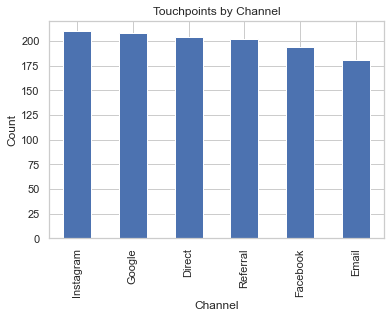

In [6]:
df['channel'].value_counts().plot(kind = 'bar', title = 'Touchpoints by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()

## First-Touch Attribution

First-Touch Attribution is a model that assigns 100% of the credit for a conversion or sale to the first marketing channel a user interacted with. It is commonly used to evaluate channels responsible for top-of-funnel awareness.

**Pros:**

* Great for measuring brand discovery effectiveness.

* Simple and easy to implement.

**Cons:**

* Ignores the impact of later touchpoints.

* May undervalue nurturing and closing channels.

In [7]:
first_touch = df.sort_values(['user_id', 'timestamp']).drop_duplicates('user_id', keep = 'first')
first_touch = first_touch[first_touch['converted'] == 1]

In [8]:
first_touch_attribution = first_touch.groupby('channel')['revenue'].sum().reset_index()
first_touch_attribution[['channel', 'revenue']]
first_touch_attribution

,channel,revenue
0,Direct,5550.39
1,Email,5046.82
2,Facebook,5038.59
3,Google,5561.42
4,Instagram,4781.47
5,Referral,4078.12


## Last-Touch Attribution

Last-Touch Attribution assigns 100% of the credit for a conversion to the final marketing channel a user interacted with before converting.  It is often used to identify closing or bottom-of-funnel channels.

**Pros:**

* Useful for identifying channels that close deals.

* Simple to track and attribute.

**Cons:**

* Ignores earlier touchpoints that may have significantly influenced the customer.

* May overvalue retargeting or direct channels.

In [9]:
last_touch = df.sort_values(['user_id', 'timestamp']).drop_duplicates('user_id', keep = 'last')
last_touch = last_touch[last_touch['converted'] == 1]

In [10]:
last_touch_attribution = last_touch.groupby('channel')['revenue'].sum().reset_index()
last_touch_attribution[['channel', 'revenue']]
last_touch_attribution

,channel,revenue
0,Direct,3930.72
1,Email,5270.05
2,Facebook,5373.90
3,Google,5156.02
4,Instagram,7064.96
5,Referral,4426.80


# Linear Attribution

Linear Attribution distributes the conversion credit equally across all touchpoints in a user’s journey.

This model assumes that every interaction contributes equally to the final conversion and is useful for analyzing the full-funnel impact of marketing channels.

**Pros:**

* Provides a balanced view of all channel contributions.

* Highlights the importance of nurturing across the funnel.

**Cons:**

* Oversimplifies the influence of each step.

* Doesn’t account for the relative weight or timing of touchpoints.

In [11]:
# Step 1: Filter only converted users
converted_df = df[df['converted'] == 1].copy()

# Step 2: For each converted user, assign total revenue to all touchpoints equally
converted_df['touch_count'] = converted_df.groupby('user_id')['channel'].transform('count')
converted_df['revenue_share'] = converted_df['revenue'] / converted_df['touch_count']

# Step 3: Group by channel to calculate total revenue per channel
linear_attribution = converted_df.groupby('channel')['revenue_share'].sum().reset_index()
linear_attribution.columns = ['channel', 'linear_touch_revenue']

linear_attribution

,channel,linear_touch_revenue
0,Direct,4763.214167
1,Email,5135.400833
2,Facebook,5338.445000
3,Google,5058.177500
4,Instagram,6569.474167
5,Referral,4469.750833


# Visualization

In [12]:
# Combine all attributions in a single df for comparision

merged = first_touch_attribution.rename(columns={"first_touch_revenue": "revenue"}) \
    .merge(last_touch_attribution.rename(columns={"last_touch_revenue": "revenue"}), 
           on='channel', how='outer', suffixes=('_first', '_last')) \
    .merge(linear_attribution.rename(columns={"linear_touch_revenue": "revenue_share"}), 
           on='channel', how='outer')

# Rename
merged = merged.rename(columns={
    "revenue_first": "first_touch_revenue",
    "revenue_last": "last_touch_revenue",
    "revenue_share": "linear_touch_revenue"
})

merged

,channel,first_touch_revenue,last_touch_revenue,linear_touch_revenue
0,Direct,5550.39,3930.72,4763.214167
1,Email,5046.82,5270.05,5135.400833
2,Facebook,5038.59,5373.90,5338.445000
3,Google,5561.42,5156.02,5058.177500
4,Instagram,4781.47,7064.96,6569.474167
5,Referral,4078.12,4426.80,4469.750833


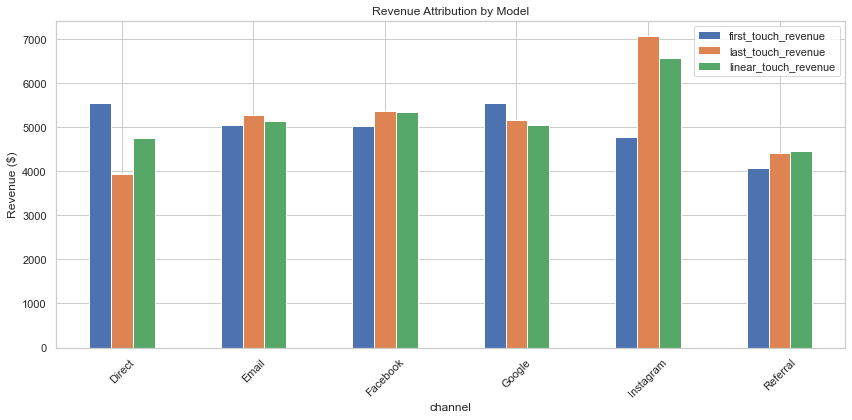

In [13]:
merged = merged.fillna(0)
merged = merged.set_index('channel')

merged.plot(kind='bar', figsize=(12, 6))
plt.title("Revenue Attribution by Model")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
print("First-Touch Total:", first_touch_attribution['revenue'].sum())
print("Last-Touch Total:", last_touch_attribution['revenue'].sum())
print("Linear Attribution Total:", linear_attribution['linear_touch_revenue'].sum())


First-Touch Total: 30056.81
Last-Touch Total: 31222.449999999993
Linear Attribution Total: 31334.4625


# Result Analysis

We implemented and compared three common attribution models - ** First-Touch, Last-Touch, and Linear ** — to evaluate how different marketing channels contribute to conversion revenue.

While the totals are close, they’re not exactly identical due to minor floating-point precision and rounding during the revenue splitting in the Linear model. However, they still reflect consistent attribution of overall revenue.

**Channel-Level Insights**

* **Instagram** dominates under **Last-Touch Attribution**, indicating it frequently plays a role in closing conversions. This suggests it's an effective channel for re-engagement or remarketing.

* **Direct and Google** perform strongly in **First-Touch Attribution**, meaning they often serve as initial discovery channels. These channels are great for awareness and top-of-funnel acquisition.

* **Linear Attribution** distributes credit across **multiple touchpoints**, highlighting channels like Email and Referral, which may not start or end journeys but still play supportive roles.

# Conclusion

Each attribution model tells a different story. For a well-rounded marketing strategy:

* Use First-Touch to assess awareness drivers,

* Use Last-Touch to evaluate conversion catalysts,

* Use Linear to identify consistently supportive channels.

Businesses should avoid relying on a single attribution model and instead adopt a blended or scenario-specific approach to optimize budget allocation and channel strategy.